In [ ]:
!pip -q install rasterio

     |████████████████████████████████| 19.3 MB 9.8 MB/s 


In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
from datetime import datetime
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio as rs
import seaborn as sns
import tensorflow as tf
import tensorflow_datasets as tfds

from google.colab import drive
from IPython.display import clear_output
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [ ]:
%%writefile constants.py
# Data
BATCH_SIZE = 32
BUFFER_SIZE = 1000
DATASET_DIR = "/content/land-cover-dataset"
DRIVE_DIR = "/content/drive/MyDrive/Colab\ Notebooks/land-cover-classification"
RECORDS_ZIP = "land-cover-classification-records.zip"
TENSORFLOW_DATASETS = "/root/tensorflow_datasets"

## Dataset Builder
BANDS = [ "B01", "B02", "B03", "B04", "B05", "B06", "B07", "B08", "B09", "B11", "B12", "B8A" ]
NUM_EXAMPLES = 22686  # Manually observed by taking the len of LandCoverClassification.patches
NUM_LABELS = 18
PATCH_SIZE = 128
BANDS_SHAPE = (PATCH_SIZE, PATCH_SIZE, len(BANDS))
LABELS_SHAPE = (PATCH_SIZE, PATCH_SIZE, 1)
STRIDE = PATCH_SIZE // 2

## Exploration
CLC_TIF = "/content/CAN_LC_2015_CAL.tif"

# Model
EPOCHS = 50
FILTERS = 64
LEARNING_RATE = 1e-4
STEPS_PER_EPOCH = (0.8 * NUM_EXAMPLES) // BATCH_SIZE
VALIDATION_SPLITS = 5
VALIDATION_STEPS = (0.2 * NUM_EXAMPLES) // BATCH_SIZE // VALIDATION_SPLITS

# Testing
TEST_DATASET = "/content/demo_site.csv"
TEST_SHAPE = (2500, 2100)

Overwriting constants.py


In [ ]:
from constants import *

In [ ]:
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Once finished with the mounted drive, run the following...

In [ ]:
drive.flush_and_unmount()

# Data

This will download the data directory to `/content/dataset`. The images were manually downloaded from Sentinel Hub using the EO browser. The dataset folder is organized as follows:

```
dataset/
    Site1/
        B01.tiff
        ...
        Labels.tiff
    Site2/
        ...
    ...
```

## Download

In [ ]:
!gdown 1emQ6BUD8pi7ZcRKvb0nFR_ynO6IaSXaY

Downloading...
From: https://drive.google.com/uc?id=1emQ6BUD8pi7ZcRKvb0nFR_ynO6IaSXaY
To: /content/land-cover-dataset.zip
100% 2.50G/2.50G [00:25<00:00, 98.5MB/s]


In [ ]:
!unzip -qq land-cover-dataset.zip

Or just copy the `.tfrecord`s instead





In [ ]:
!mkdir -p $TENSORFLOW_DATASETS

In [ ]:
!cp -r $DRIVE_DIR/$RECORDS_ZIP $TENSORFLOW_DATASETS

In [ ]:
%pushd $TENSORFLOW_DATASETS
!unzip $RECORDS_ZIP
%popd

## Dataset Builder

In [ ]:
%%writefile land_cover_classification.py
from pathlib import Path

import numpy as np
import rasterio as rs
import tensorflow as tf
import tensorflow_datasets as tfds
import textwrap

from constants import *


class LandCoverClassification(tfds.core.GeneratorBasedBuilder):
    VERSION = tfds.core.Version("0.0.1")

    MANUAL_DOWNLOAD_INSTRUCTIONS = textwrap.dedent(f"""
    The land-cover-dataset.zip should be downloaded and extracted to the manual_dir
    """)

    def _info(self):
        return tfds.core.DatasetInfo(
            builder=self,
            features=tfds.features.FeaturesDict(
                dict(
                    bands=tfds.features.Tensor(shape=BANDS_SHAPE, dtype=tf.float32),
                    labels=tfds.features.Tensor(shape=LABELS_SHAPE, dtype=tf.uint8),
                )
            ),
            supervised_keys=("bands", "labels"),
        )
    
    @classmethod
    def _get_bands_generator(cls, site_path):
        for band in BANDS:
            band_path = site_path / f"{band}.tiff"
            with rs.open(band_path) as tiff:
                yield tiff.read(1)  # The TIFF shape should be 1 x R X C

    def _generate_examples(self, manual_dir):
        return self.patches(dataset_dir=manual_dir)

    def _get_labels(site_path):
        labels_path = site_path / "Labels.tiff"
        with rs.open(labels_path) as tiff:
            return tiff.read(1)  # The TIFF shape should be 1 x R X C

    def mode(labels):
        values, counts = np.unique(labels.reshape(-1), return_counts=True)
        argmax = counts.argmax()
        return values[argmax]

    def _split_generators(self, dl_manager):
        return [
            tfds.core.SplitGenerator(
                name=tfds.Split.TRAIN, gen_kwargs={ "manual_dir": dl_manager.manual_dir })]

    @classmethod
    def patches(cls, dataset_dir, patch_size=PATCH_SIZE, stride=STRIDE):
        dataset_path = Path(dataset_dir)
        for site_path in dataset_path.iterdir():
            bands = [band for band in cls._get_bands_generator(site_path)]
            bands = np.dstack(bands)
            labels = cls._get_labels(site_path) 
            labels[labels > NUM_LABELS] = cls.mode(labels)  # Clamped labels from qGIS have values of 255
            labels -= 1  # Shift 1-19 to 0-18

            if bands.shape[:2] != labels.shape[:2]:
                raise ValueError(
                    f"Bands shape {bands.shape[:2]} differs from labels shape {labels.shape[:2]}")

            rows, cols = labels.shape
            r_start = 0
            while r_start + patch_size <= rows:
                c_start = 0
                while c_start + patch_size <= cols:
                    r_end, c_end = r_start + patch_size, c_start + patch_size
                    yield f"{site_path.name}_{r_start}_{c_start}", dict(
                        bands=bands[r_start:r_end, c_start:c_end, :], 
                        labels=labels[r_start:r_end, c_start:c_end, np.newaxis]
                    )
                    c_start += stride
                r_start += stride

Writing land_cover_classification.py


In [ ]:
from land_cover_classification import *

In [ ]:
dataset_builder = LandCoverClassification()
dataset_builder.download_and_prepare(
    download_dir=None,
    download_config=tfds.download.DownloadConfig(manual_dir=DATASET_DIR)
)

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/land_cover_classification/0.0.1.incompleteUNSKMO/land_cover_classification-train.tfrecord


  0%|          | 0/22686 [00:00<?, ? examples/s]

Dataset land_cover_classification downloaded and prepared to /root/tensorflow_datasets/land_cover_classification/0.0.1. Subsequent calls will reuse this data.


Save the records to drive

In [ ]:
%pushd $TENSORFLOW_DATASETS
!zip -q -r $RECORDS_ZIP land_cover_classification/0.0.1
%popd

/root/tensorflow_datasets
/content
popd -> /content


In [ ]:
!cp $TENSORFLOW_DATASETS/$RECORDS_ZIP $DRIVE_DIR

## Exploration

In [ ]:
ds = dataset_builder.as_dataset(split="train")

### Ground truth

In [ ]:
!gdown 1db6viZTDWvQwNI2ZGV-K_rMzTXplruyA

Downloading...
From: https://drive.google.com/uc?id=1db6viZTDWvQwNI2ZGV-K_rMzTXplruyA
To: /content/CAN_LC_2015_CAL.tif
100% 1.67G/1.67G [00:14<00:00, 113MB/s]


In [ ]:
label_counts = np.zeros((20,))
with rs.open(CLC_TIF) as src:
    for ji, window in src.block_windows(1):
        r = src.read(1, window=window)
        unique, counts = np.unique(r, return_counts=True)
        label_counts[unique] += counts
label_counts

array([1.87372382e+10, 2.49379534e+09, 2.67217296e+08, 0.00000000e+00,
       0.00000000e+00, 4.96230868e+08, 6.76348893e+08, 0.00000000e+00,
       7.64148770e+08, 9.60000000e+01, 4.61825005e+08, 2.89308311e+08,
       9.97539820e+08, 6.56912166e+08, 4.06328393e+08, 5.54398013e+08,
       1.03146982e+09, 6.09295840e+07, 2.27362409e+09, 2.33035312e+08])

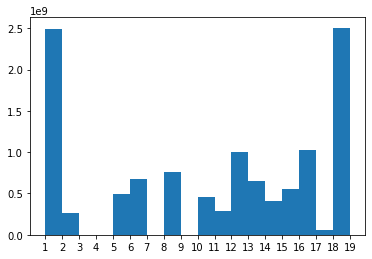

In [ ]:
x = np.arange(1, 20)
plt.hist(x, bins=x, weights=label_counts[1:])
plt.xticks(x)
plt.show()

### Distribution of labels in dataset

In [ ]:
label_counts = np.zeros((19,))
for example in ds:
    unique, counts = np.unique(example["labels"], return_counts=True)
    label_counts[unique] += counts
label_counts

array([9.9853494e+07, 1.5254600e+05, 0.0000000e+00, 0.0000000e+00,
       3.0987457e+07, 4.9994951e+07, 0.0000000e+00, 1.9119345e+07,
       0.0000000e+00, 3.0745477e+07, 9.5980000e+03, 3.9473600e+05,
       5.5446400e+05, 1.2379118e+07, 8.9333039e+07, 1.0883219e+07,
       6.0164860e+06, 2.1263494e+07, 0.0000000e+00])

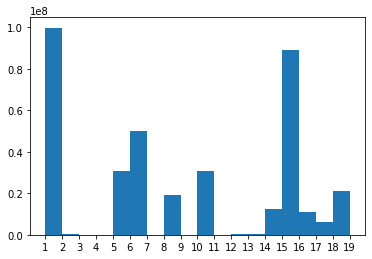

In [ ]:
x = np.arange(1, 20)
plt.hist(x, bins=x, weights=label_counts)
plt.xticks(x)
plt.show()

## Sample weights

The label counts are found from the dataset label counts

In [ ]:
label_counts = np.array([
    9.9853494e+07, 1.5254600e+05, 0.0000000e+00, 0.0000000e+00,
    3.0987457e+07, 4.9994951e+07, 0.0000000e+00, 1.9119345e+07,
    0.0000000e+00, 3.0745477e+07, 9.5980000e+03, 3.9473600e+05,
    5.5446400e+05, 1.2379118e+07, 8.9333039e+07, 1.0883219e+07,
    6.0164860e+06, 2.1263494e+07, 0.0000000e+00
])

In [ ]:
n_samples = np.sum(label_counts)
class_weights = np.repeat([n_samples], NUM_LABELS + 1)
class_weights /= (label_counts + 1)
class_weights /= NUM_LABELS
class_weights[[2, 3, 6]] = 0
class_weights

array([2.06795980e-01, 1.35363536e+02, 0.00000000e+00, 0.00000000e+00,
       6.66376097e-01, 4.13027726e-01, 0.00000000e+00, 1.08002132e+00,
       2.06493013e+07, 6.71620761e-01, 2.15119297e+03, 5.23115425e+01,
       3.72418481e+01, 1.66807519e+00, 2.31149655e-01, 1.89735219e+00,
       3.43211933e+00, 9.71115112e-01, 2.06493013e+07])

In [ ]:
class_weights = [
    2.06795980e-01, 1.35363536e+02, 0.00000000e+00, 0.00000000e+00,
    6.66376097e-01, 4.13027726e-01, 0.00000000e+00, 1.08002132e+00,
    2.06493013e+07, 6.71620761e-01, 2.15119297e+03, 5.23115425e+01,
    3.72418481e+01, 1.66807519e+00, 2.31149655e-01, 1.89735219e+00,
    3.43211933e+00, 9.71115112e-01, 2.06493013e+07
]

In [ ]:
def add_sample_weights(bands, labels):
    sample_weights = tf.gather(class_weights, indices=tf.cast(labels, tf.int32))
    return bands, labels, sample_weights

## Augmentation

The augmentation and batching is taken from [Image segmentation](https://www.tensorflow.org/tutorials/images/segmentation)

In [ ]:
class Augment(tf.keras.layers.Layer):
    def __init__(self, seed=RANDOM_SEED):
        super().__init__()
        # both use the same seed, so they'll make the same random changes.
        self.augment_inputs = tf.keras.layers.RandomFlip(seed=seed)
        self.augment_labels = tf.keras.layers.RandomFlip(seed=seed)

    def call(self, inputs, labels):
        inputs = self.augment_inputs(inputs)
        labels = self.augment_labels(labels)
        return inputs, labels

## Splits & Batches

In [ ]:
train_ds, val_ds = dataset_builder.as_dataset(
    split=["train[:80%]", "train[80%:]"],
    shuffle_files=True
)

In [ ]:
def get_bands_and_labels(example):
    return example["bands"], example["labels"]

In [ ]:
train_batches = (
    train_ds
    .map(get_bands_and_labels, num_parallel_calls=tf.data.AUTOTUNE)
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .map(add_sample_weights, num_parallel_calls=tf.data.AUTOTUNE)
    .prefetch(buffer_size=tf.data.AUTOTUNE))

val_batches = (
    val_ds
    .map(get_bands_and_labels, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE))

# Model

## U-Net

The U-Net is adapted from [VidushiBhatia/U-Net-Implementation](https://github.com/VidushiBhatia/U-Net-Implementation/blob/main/U_Net_for_Image_Segmentation_From_Scratch_Using_TensorFlow_v4.ipynb)

In [ ]:
def encoder_block(inputs, filters, dropout_rate=0, include_pooling=True, **convargs):
    x = tf.keras.layers.Conv2D(filters, **convargs)(inputs)
    x = tf.keras.layers.Conv2D(filters, **convargs)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    if dropout_rate:     
        x = tf.keras.layers.Dropout(dropout_rate)(x)
    skip = x
    if include_pooling:
        x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
    return x, skip

In [ ]:
def decoder_block(inputs, skip, filters, dropout_rate=0, pool_size=(2, 2), **convargs):
    x = tf.keras.layers.Conv2DTranspose(
        filters, kernel_size=3, strides=2, padding="same")(inputs)
    x = tf.keras.layers.concatenate([x, skip], axis=3)
    x = tf.keras.layers.Conv2D(filters, **convargs)(x)
    return tf.keras.layers.Conv2D(filters, **convargs)(x)

In [ ]:
def unet(input_shape, n_classes, dilation_rate=1, filters=FILTERS, learning_rate=LEARNING_RATE):
    inputs = tf.keras.Input(shape=input_shape)
    convargs = dict(
        kernel_size=3, 
        padding="same", 
        dilation_rate=dilation_rate, 
        activation="relu", 
        kernel_initializer="glorot_uniform"
    )

    # encoder
    enc1, skip1 = encoder_block(inputs, filters, **convargs)
    enc2, skip2 = encoder_block(enc1, filters * 2, **convargs)
    enc3, skip3 = encoder_block(enc2, filters * 4, **convargs)
    enc4, skip4 = encoder_block(enc3, filters * 8, dropout_rate=0.3, **convargs)
    enc5, _ = encoder_block(enc4, filters * 16, dropout_rate=0.3, include_pooling=False, **convargs)

    # decoder
    dec6 = decoder_block(enc5, skip4, filters * 8, **convargs)
    dec7 = decoder_block(dec6, skip3, filters * 4, **convargs)
    dec8 = decoder_block(dec7, skip2, filters * 2, **convargs)
    dec9 = decoder_block(dec8, skip1, filters, **convargs)

    conv10 = tf.keras.layers.Conv2D(filters, **convargs)(dec9)
    outputs = tf.keras.layers.Conv2D(n_classes, 1, padding="same")(conv10)

    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="unet")
    model.compile(
        optimizer=tf.optimizers.Adam(learning_rate=LEARNING_RATE),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"])
    
    return model

In [ ]:
model = unet(BANDS_SHAPE, n_classes=NUM_LABELS, filters=FILTERS)

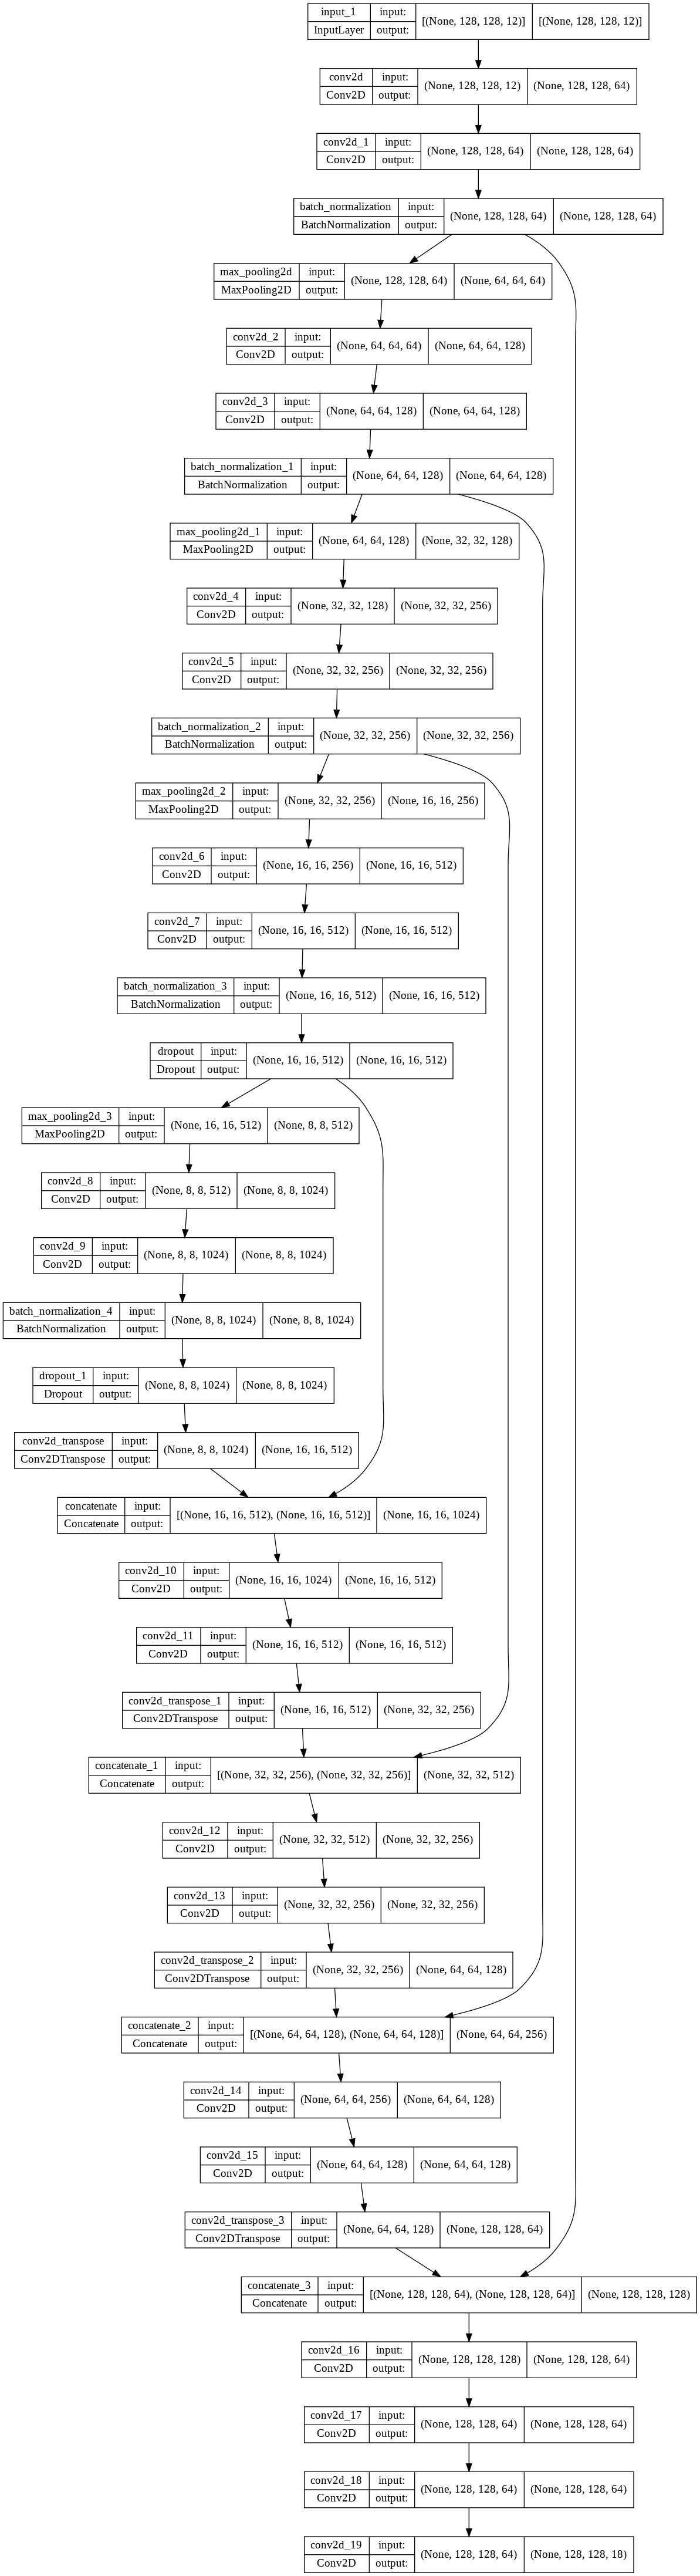

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

## Training

In [ ]:
MODEL_SAVE = f"{model.name}.h5"

In [ ]:
for example in val_ds.take(1):
    example_bands, example_labels = example["bands"], example["labels"]

In [ ]:
class DisplayPredictionCallback(tf.keras.callbacks.Callback):
    def __init__(self, example_bands, example_labels):
        self.example_bands = example_bands
        self.example_labels = example_labels

    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        x = self.example_bands[tf.newaxis, ...]
        preds = model.predict(x)
        labels = tf.math.argmax(preds, axis=-1)
        labels = labels[..., tf.newaxis]

        _, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 8))
        ax1.set_title("True Labels")
        ax1.imshow(tf.keras.utils.array_to_img(self.example_labels))
        ax1.axis("off")
        ax2.set_title("Predicted Labels")
        ax2.imshow(tf.keras.utils.array_to_img(labels[0]))
        ax2.axis("off")
        plt.show()

        print(f"\nPrediction after epoch {epoch + 1}\n")

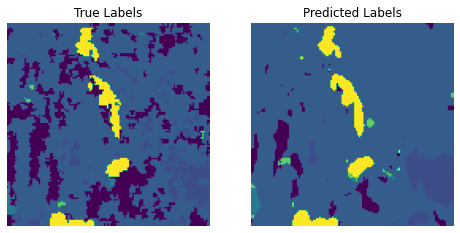


Prediction after epoch 50

567/567 [==============================] - 143s 253ms/step - loss: 0.5420 - accuracy: 0.7077 - val_loss: 0.8252 - val_accuracy: 0.6937


In [ ]:
history = model.fit(
    train_batches,
    epochs=EPOCHS,
    validation_data=val_batches,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=VALIDATION_STEPS,
    callbacks=[
        DisplayPredictionCallback(example_bands, example_labels),
        tf.keras.callbacks.ModelCheckpoint(MODEL_SAVE, save_best_only=True)
    ]
)

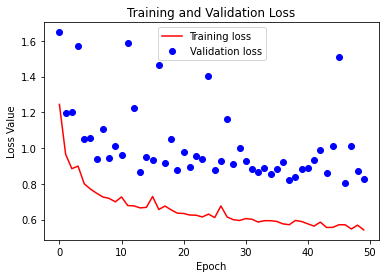

In [ ]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]

plt.figure()
plt.plot(history.epoch, loss, "r", label="Training loss")
plt.plot(history.epoch, val_loss, "bo", label="Validation loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss Value")
plt.legend()
plt.show()

# Loading model

In [ ]:
!cp $MODEL_SAVE $DRIVE_DIR

In [ ]:
!gdown 1ARjOomw3Ztfpu09ApToTTUyGxmjO9UL_

Downloading...
From: https://drive.google.com/uc?id=1ARjOomw3Ztfpu09ApToTTUyGxmjO9UL_
To: /content/unet.h5
100% 415M/415M [00:06<00:00, 63.3MB/s]


In [ ]:
model = tf.keras.models.load_model("unet.h5")  # Note that the model name is hardcoded!

# Testing

## Download

The testing data is take from the [project_example.ipynb](https://colab.research.google.com/drive/1Odk9BFvriINUrD8Lma-fQ8up5pKih3ec?usp=sharing)

In [ ]:
!gdown 12NT2Ejt7DsujvyAmmlB8VrsDY7irtFEh

Downloading...
From: https://drive.google.com/uc?id=12NT2Ejt7DsujvyAmmlB8VrsDY7irtFEh
To: /content/demo_site.csv
100% 458M/458M [00:13<00:00, 34.4MB/s]


## DataFrames

In [ ]:
test_df = pd.read_csv(TEST_DATASET)

In [ ]:
labels_series = test_df["land_cover"]
labels_series = labels_series.astype("uint8")
labels_series -= 1  # shift
bands_df = test_df.drop(columns="land_cover", axis=1)
bands_df = bands_df.astype("float32")

In [ ]:
bands_df.head()

,B01,B02,B03,B04,B05,B06,B07,B08,B09,B11,B12,B8A
0,0.0269,0.0323,0.0486,0.0336,0.0826,0.2044,0.2381,0.2459,0.2557,0.1522,0.0807,0.2563
1,0.0261,0.0310,0.0492,0.0307,0.0814,0.2132,0.2465,0.2552,0.2593,0.1454,0.0743,0.2621
2,0.0260,0.0285,0.0438,0.0239,0.0693,0.1920,0.2221,0.2269,0.2242,0.1182,0.0574,0.2336
3,0.0272,0.0295,0.0406,0.0234,0.0581,0.1477,0.1752,0.1783,0.1839,0.0773,0.0370,0.1854
4,0.0248,0.0293,0.0451,0.0307,0.0769,0.2037,0.2391,0.2461,0.2592,0.1472,0.0764,0.2564


## Distribution of test labels

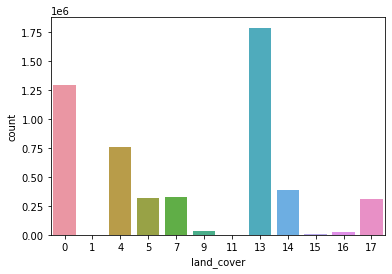

In [ ]:
sns.countplot(x=labels_series)

## Reshape the tabular data into an image

In [ ]:
im_bands = (bands_df[band].to_numpy().reshape(TEST_SHAPE) for band in BANDS)
im_bands = (im_band for im_band in im_bands)
im_bands = np.dstack(list(im_bands))
im_labels = labels_series.to_numpy().reshape(TEST_SHAPE)

## Predictions

In [ ]:
def make_predictions(
    model, 
    bands,
    n_classes=NUM_LABELS, 
    input_shape=TEST_SHAPE, 
    patch_size=PATCH_SIZE
):
    labels = np.zeros(TEST_SHAPE)
    rows, cols = input_shape
    for r_start in range(0, rows // patch_size * patch_size, patch_size):
        for c_start in range(0, cols // patch_size * patch_size, patch_size):
            r_end, c_end = r_start + patch_size, c_start + patch_size
            x = bands[r_start:r_end, c_start:c_end, :]
            x = x[np.newaxis, :]
            preds = model.predict(x)
            argmax = np.argmax(preds[0], axis=-1)
            labels[r_start:r_end, c_start:c_end] = argmax
    
    # row edge
    c_start = cols - patch_size
    for r_start in range(0, rows // patch_size * patch_size, patch_size):
        r_end = r_start + patch_size
        x = bands[r_start:r_end, c_start:]
        x = x[np.newaxis, :]
        preds = model.predict(x)
        argmax = np.argmax(preds[0], axis=-1)
        labels[r_start:r_end, c_start:] = argmax
    
    # cols edge
    r_start = rows - patch_size
    for c_start in range(0, cols // patch_size * patch_size, patch_size):
        c_end = c_start + patch_size
        x = bands[r_start:, c_start:c_end]
        x = x[np.newaxis, :]
        preds = model.predict(x)
        argmax = np.argmax(preds[0], axis=-1)
        labels[r_start:, c_start:c_end] = argmax

    # row/col corner
    x = bands[-patch_size:, -patch_size:]
    x = x[np.newaxis, :]
    preds = model.predict(x)
    argmax = np.argmax(preds[0], axis=-1)
    labels[-patch_size:, -patch_size:] = argmax

    return labels

The following takes a decent amount of time as it's sliding a patch along the image

In [ ]:
predicted_labels = make_predictions(model, im_bands)

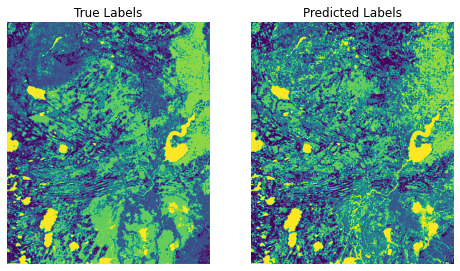

In [ ]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 8))
ax1.set_title("True Labels")
ax1.imshow(tf.keras.utils.array_to_img(im_labels[..., np.newaxis]))
ax1.axis("off")
ax2.set_title("Predicted Labels")
ax2.imshow(tf.keras.utils.array_to_img(predicted_labels[..., np.newaxis]))
ax2.axis("off")
plt.show()

In [ ]:
y_true = im_labels.reshape(-1)
y_pred = predicted_labels.reshape(-1)

In [ ]:
accuracy_score(y_true, y_pred)

0.4540817142857143

In [ ]:
balanced_accuracy_score(y_true, y_pred)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


0.35413772458488024

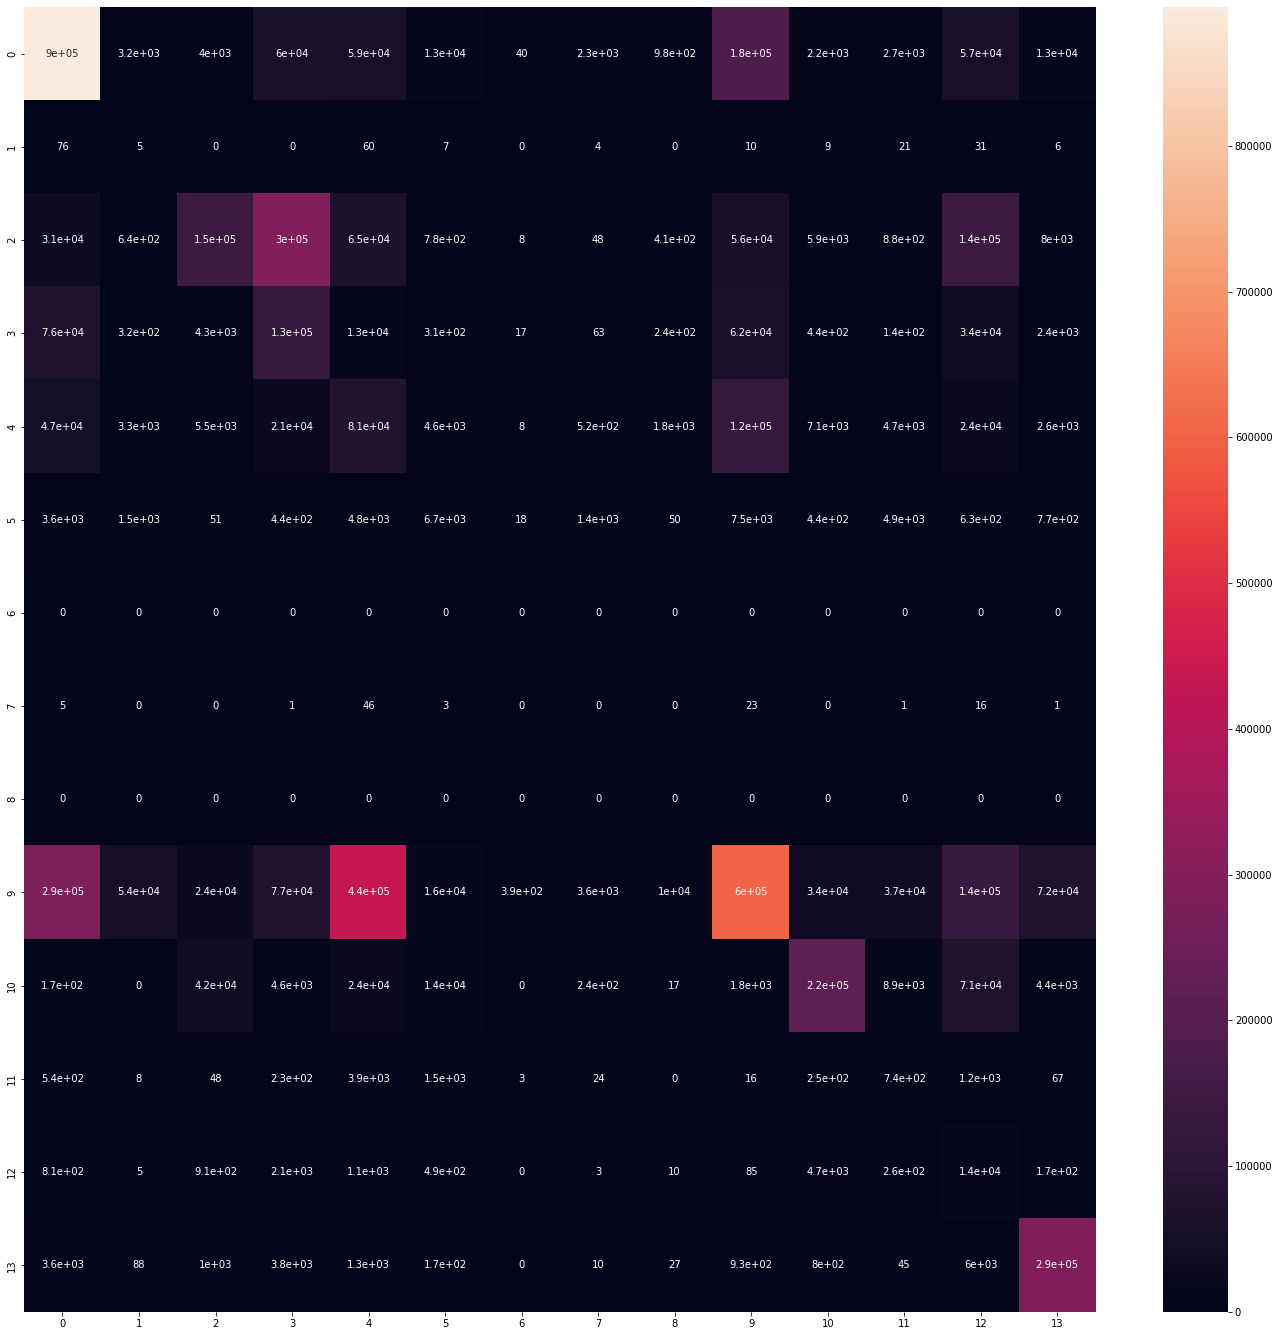

In [ ]:
mtx = confusion_matrix(y_true, y_pred)
_, ax = plt.subplots(figsize=(24, 24))
sns.heatmap(mtx, annot=True, ax=ax)